# Problem pierwszy - położenie grzejnika

W tym tekście skupimy się na zamodelowaniu problemu, jakim jest położenie grzejnika w stosunku do okna. Zbadamy, jak zmienia się temperatura w pomieszczeniu, jakie jest odchylenie standardowe temperatury, a także jakie jest zużycie energii w zależności od położenia grzejnika.

## Wprowadzenie teoretyczne

W naszym przypadku równanie ciepła na obszarze $\Omega$ ma postać:

$$\begin{cases}
\frac{\partial u}{\partial t} = \alpha \Delta u + f_i(x, u), &\quad x \in R_i, t \in [0, T], i \in \{1, ..., N_{rooms}\}  \\
\frac{\partial u}{\partial \vec n} = g_i(x, u), &\quad x \in W_i, t \in [0, t], i \in \{ 1, ..., N_{windows}\} \\
\frac{\partial u}{\partial \vec n} = h_i(x, u), &\quad x \in \mathcal{W}_i, t \in [0, T], i \in \{1, N_{walls} \}  \\
u(x, 0) = u_0(x) 
\end{cases}$$

gdzie $\alpha = 2.239 * 10^{-5}$ jest [współczynnikiem wyrównania temperatur w temperaturze 25 stopni](https://www.engineeringtoolbox.com/air-thermal-diffusivity-d_2011.html) $f_i(x, u) = u \cdot \frac{P \cdot r}{p \cdot |\mathcal{R_i}| \cdot c}$ dla $\mathcal{R_i}$ będącego obszarem umiejscowienia grzejnika. Fizyczne wartości przyjęte dla tego równania to:
- P = 915.0 [Grzejnik 1. typu 600x1000 75/65](https://ezelazny.pl/blog/post/grzejniki-perfekt-tabela-mocy)
- r = 297.05 [J/(kg * K)](https://pl.wikipedia.org/wiki/Sta%C5%82a_gazowa)
- p = 101325.0 [Ciśnienie powietrza w temperaturze 20 stopni Celsjusza w Pascalach](https://pl.wikipedia.org/wiki/Ci%C5%9Bnienie_atmosferyczne)
- c = 1005.0 [Ciepło właściwe powietrza](https://pl.wikipedia.org/wiki/Ciep%C5%82o_w%C5%82a%C5%9Bciwe#HeroSection)

Z kolei funkcje $g_i(x, u)$ oraz $h_i(x, u)$ są postaci $$\frac{\partial u}{\partial \vec n} = - \frac{\lambda_{mat}}{\lambda_{air}} (u - u_{zew})$$ gdzie $\lambda_{mat}$ to przewodność cieplna dla okna i ściany. Wyliczymy go przy pomocy współczynnika $U$ oznaczającego współczynnik przeinkania ciepła. Można wtedy uznać, że $$\lambda_{mat} = U \cdot d$$ gdzie $d$ oznacza grubość materiału (w naszym przypadku będzie to hx lub hy). Według [Rozporządzenia ministra infrastruktury z dnia 12 kwietnia 2002 rokuw sprawie warunków technicznych, jakim powinny odpowiadać budynki i ich usytuowanie](https://sip.lex.pl/akty-prawne/dzu-dziennik-ustaw/warunki-techniczne-jakim-powinny-odpowiadac-budynki-i-ich-usytuowanie-16964625) możemy zobaczyć w załączniku drugim, że wartość $U$ dla ściany zewnętrznej powinna być nie większa niż $0.2$, natomiast dla okna nie większa niż $0.9$. Na podstawie tych wartości wyznaczymy odpowiednie lambdy już w odpowiednim kodzie.

Wykonamy obliczenia metodą niejawną z krokiem czasowym $h_t = 1.0$ reprezentującym jedną sekundę. Czas wykonania będzie wynosił 86400 sekund (a zatem 24 godziny). W kodzie mamy pewne założenia:
- temperatura początkowa wynosi 290K (około 17 stopni Celsjusza),
- temperatura na zewnątrz wynosi 260K (około -10 stopni Celsjusza),
- grzejnik jest ustawiony na temperaturę 298K (około 25 stopni Celsjusza),
- przyjmujemy dla uproszczenia, że czujniki są rozmieszczone w całym pomieszczeniu, a zatem grzejnik wyłącza się, gdy średnia temperatura w pomieszczeniu wyniesie 298K,
- przyjmujemy, że grzejnik nie może mieć temperatury wyższej niż 348K (około 75 stopni Celsjusza) i jeśli tę temperaturę przekroczy również się wyłączy,
- przyjmujemy wymiary pokoju 2mx2m (przedział x oraz y $(0, 2)$).

Przy metodzie niejawnej będziemy rozwiązywać równanie: $$Au^{n+1} = u^n + h_t * f(x, u^n)$$ gdzie $A$ to macierz postaci $$A = Id - \alpha h_t L$$ Natomiast $L$ to macierz laplasjanu postaci $$L = \frac{Id_y \otimes D_2}{h_x^2} + \frac{D_2 \otimes Id_x}{h_y^2}$$ gdzie $D_2$ to macierz drugich pochodnych. Na brzegach zmieniam odpowiednie elementy macierzy $A$ na elementy odpowiednej jednej z czterech macierzy $B$  postaci 
\begin{aligned}
B^x_{forward} &= \frac{(Id_y \otimes D^x_{1forward})}{h_x} + \frac{\lambda_{mat}}{\lambda_{air}}Id \\
B^x_{backward} &= \frac{(Id_y \otimes D^x_{1backward})}{h_x} + \frac{\lambda_{mat}}{\lambda_{air}}Id \\
B^y_{forward} &= \frac{(D^y_{1forward} \otimes Id_x)}{h_y} + \frac{\lambda_{mat}}{\lambda_{air}}Id \\
B^y_{backward} &= \frac{(D^y_{1backward} \otimes Id_x)}{h_x} + \frac{\lambda_{mat}}{\lambda_{air}}Id
\end{aligned}


gdzie macierze $D_1$ to odpowiednie macierze pierwszych pochodnych zależne od kierunku przepływu powietrza.

Zbadamy trzy położenia grzejnika - przy samym oknie, naprzeciwko okna oraz na ścianie po lewej stronie od okna. Poniżej widać kod wraz z wykresami prezentującymi końcową mapę ciepła w pokoju. W oddzielnym pliku animacja_problem1.py można zobaczyć animację, jak zmienia się temperatura z upływem kolejnych minut.

In [5]:
import sys
from pathlib import Path

NOTEBOOK_DIR = Path().resolve()
PROJECT_ROOT = NOTEBOOK_DIR.parent

print("Notebook:", NOTEBOOK_DIR)
print("Project root:", PROJECT_ROOT)

sys.path.insert(0, str(PROJECT_ROOT))
print("Added to sys.path")

Notebook: C:\Users\ameli\Desktop\Studia Programowanie\Ciepło modelowanie\notebooks
Project root: C:\Users\ameli\Desktop\Studia Programowanie\Ciepło modelowanie
Added to sys.path


In [6]:
import pipelines
print("pipelines found at:", pipelines.__file__)

pipelines found at: C:\Users\ameli\Desktop\Studia Programowanie\Ciepło modelowanie\pipelines\__init__.py


100%|██████████| 432000/432000 [04:57<00:00, 1451.16it/s]



--- Statystyki: Grzejnik: Pod oknem ---
Średnia: 25.02°C
Sigma (std): 14.64°C
Max: 64.37°C | Min: 2.62°C

--- Statystyki: Grzejnik: Naprzeciw okna ---
Średnia: 25.01°C
Sigma (std): 18.52°C
Max: 69.38°C | Min: -2.04°C

--- Statystyki: Grzejnik: Z boku ---
Średnia: 25.04°C
Sigma (std): 18.44°C
Max: 71.62°C | Min: -1.21°C


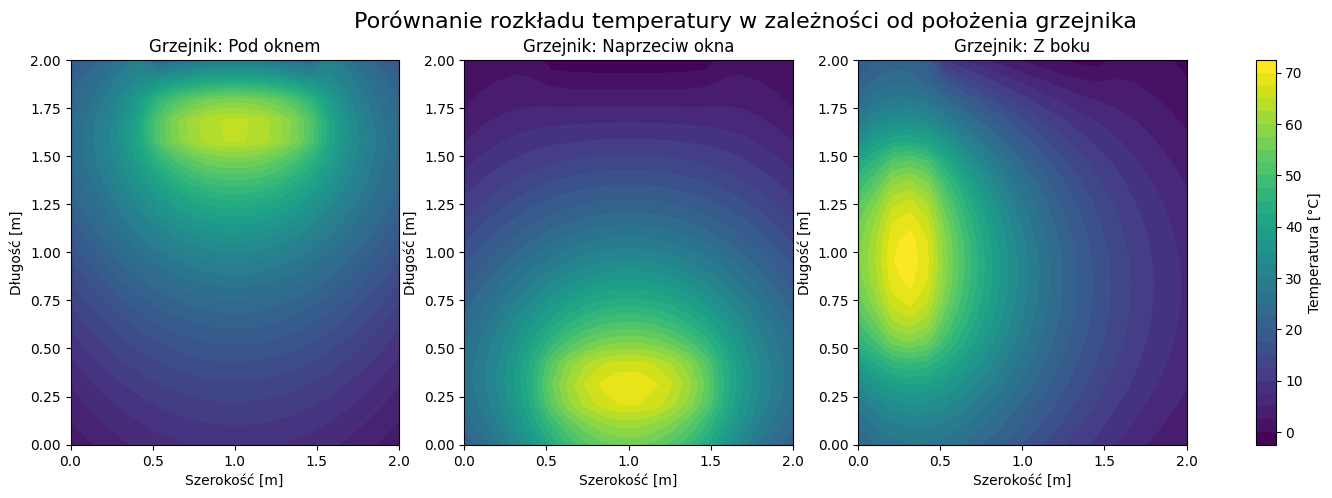

Zużycie energii w pierwszym pokoju: 549.230398298523
Zużycie energii w drugim pokoju: 413.0679367531914
Zużycie energii w trzecim pokoju: 435.6609831131641


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from pipelines.room import Room
from pipelines.heater import Heater
from pipelines.heatercontroller import HeaterController
from pipelines.boundaryconditions import BoundaryConditions
from pipelines.heatsolver import HeatSolver
import matplotlib.animation as animation

room_width = 2.0
room_length = 2.0

c = 1005.0
p = 101325.0
P = 915.0
r = 287.05

U_window = 0.9
U_wall = 0.2
lambda_air = 0.0262

ht = 1.0
T = 3600.0 * 24
t = np.arange(0, T, ht)

Nx, Ny = 20, 20
x = np.linspace(0, room_width, Nx)
y = np.linspace(0, room_length, Ny)
hx, hy = x[1] - x[0], y[1] - y[0]
room1 = Room(Nx, Ny, hx, hy, 0, 0, room_width, room_length)
room2 = Room(Nx, Ny, hx, hy, 0, 0, room_width, room_length)
room3 = Room(Nx, Ny, hx, hy, 0, 0, room_width, room_length)
lambda_wall = U_wall * hx
lambda_window = U_window * hx

X, Y = np.meshgrid(x, y)
X_flat, Y_flat = X.flatten(), Y.flatten()

T_out = 263.0
T_initial = 293.0
T_target = 298.0

window_width = 1.0
window_center = room_width / 2
window_x_min = window_center - window_width / 2
window_x_max = window_center + window_width / 2
ind_window = (Y_flat == y[-1]) & (X_flat >= window_x_min) & (X_flat <= window_x_max)
room1.add_window("top", ind_window, lambda_window)
room2.add_window("top", ind_window, lambda_window)
room3.add_window("top", ind_window, lambda_window)

ind_left = np.where(X_flat == x[0], True, False)
ind_right = np.where(X_flat == x[-1], True, False)
ind_bottom = np.where(Y_flat == y[0], True, False)
ind_top = np.where(Y_flat == y[-1], True, False) & ~ind_window
room1.add_walls("left", ind_left, lambda_wall)
room1.add_walls("right", ind_right, lambda_wall)
room1.add_walls("bottom", ind_bottom, lambda_wall)
room1.add_walls("top", ind_top, lambda_wall)
room2.add_walls("left", ind_left, lambda_wall)
room2.add_walls("right", ind_right, lambda_wall)
room2.add_walls("bottom", ind_bottom, lambda_wall)
room2.add_walls("top", ind_top, lambda_wall)
room3.add_walls("left", ind_left, lambda_wall)
room3.add_walls("right", ind_right, lambda_wall)
room3.add_walls("bottom", ind_bottom, lambda_wall)
room3.add_walls("top", ind_top, lambda_wall)

radiator_width = 1.0
offset = 2 * hy
rad_x_min = window_center - radiator_width / 2
rad_x_max = window_center + radiator_width / 2

radiator_height = radiator_width
rad_y_center = room_length / 2
rad_y_min = rad_y_center - radiator_height / 2
rad_y_max = rad_y_center + radiator_height / 2

ind_radiator_top = (Y_flat <= room_width - offset) & (Y_flat > room_width - offset - 3 * hy) & (X_flat >= rad_x_min) & (X_flat <= rad_x_max)
heater_top = Heater(ind_radiator_top, P, T_target)
room1.add_heater("heater", heater_top)
ind_radiator_bottom = (Y_flat >= offset) & (Y_flat < offset + 3 * hy) & (X_flat >= rad_x_min) & (X_flat <= rad_x_max)
heater_bottom = Heater(ind_radiator_bottom, P, T_target)
room2.add_heater("heater", heater_bottom)
ind_radiator_left = (X_flat >= offset) & (X_flat < offset + 3 * hx) & (Y_flat >= rad_y_min) & (Y_flat <= rad_y_max)
heater_left = Heater(ind_radiator_left, P, T_target)
room3.add_heater("heater", heater_left)

bc1 = BoundaryConditions(room1)
bc2 = BoundaryConditions(room2)
bc3 = BoundaryConditions(room3)
solver1 = HeatSolver(room1, ht)
solver1.apply_boundary_conditions(bc1)
solver2 = HeatSolver(room2, ht)
solver2.apply_boundary_conditions(bc2)
solver3 = HeatSolver(room3, ht)
solver3.apply_boundary_conditions(bc3)

controller1 = HeaterController(room1)
controller2 = HeaterController(room2)
controller3 = HeaterController(room3)

u0 = np.ones(Nx * Ny) * 290
u_current1 = np.zeros(len(u0))
u_current2 = np.zeros(len(u0))
u_current3 = np.zeros(len(u0))

energy_usage1 = []
energy_usage2 = []
energy_usage3 = []

history1 = []
history2 = []
history3 = []
save_interval = 60

for time in tqdm.tqdm(t):
    if time == t[0]:
        u_current1 = u0.copy()
        u_current2 = u0.copy()
        u_current3 = u0.copy()
    else:
        source1 = controller1.compute_source(u_current1)
        energy_usage1.append(np.sum(source1) * hx * hy)
        u_current1 = solver1.step(u_current1, source1, bc1)
        source2 = controller2.compute_source(u_current2)
        energy_usage2.append(np.sum(source2) * hx * hy)
        u_current2 = solver2.step(u_current2, source2, bc2)
        source3 = controller3.compute_source(u_current3)
        energy_usage3.append(np.sum(source3) * hx * hy)
        u_current3 = solver3.step(u_current3, source3, bc3)
        if int(time) % save_interval == 0:
            history1.append(u_current1.reshape(Nx, Ny).copy())
            history2.append(u_current2.reshape(Nx, Ny).copy())
            history3.append(u_current3.reshape(Nx, Ny).copy())
            
u_current1 = u_current1 - 273.0

u_current2 = u_current2 - 273.0

u_current3 = u_current3 - 273.0

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
results = [u_current1, u_current2, u_current3]
titles = ["Grzejnik: Pod oknem", "Grzejnik: Naprzeciw okna", "Grzejnik: Z boku"]

vmin = min(u.min() for u in results)
vmax = max(u.max() for u in results)

for i, ax in enumerate(axes):
    u_2d = results[i].reshape(Nx, Ny)
    im = ax.contourf(x, y, u_2d, levels=30, vmin=vmin, vmax=vmax)
    ax.set_title(titles[i])
    ax.set_xlabel("Szerokość [m]")
    ax.set_ylabel("Długość [m]")

    print(f"\n--- Statystyki: {titles[i]} ---")
    print(f"Średnia: {np.mean(results[i]):.2f}°C")
    print(f"Sigma (std): {np.std(results[i]):.2f}°C")
    print(f"Max: {results[i].max():.2f}°C | Min: {results[i].min():.2f}°C")

fig.colorbar(im, ax=axes.ravel().tolist(), label="Temperatura [°C]")
plt.suptitle("Porównanie rozkładu temperatury w zależności od położenia grzejnika", fontsize=16)

plt.show()


print(f"Zużycie energii w pierwszym pokoju: {np.sum(energy_usage1) * ht}")
print(f"Zużycie energii w drugim pokoju: {np.sum(energy_usage2) * ht}")
print(f"Zużycie energii w trzecim pokoju: {np.sum(energy_usage3) * ht}")


Jak widać, w pierwszym z pokoi temperatura rozchodzi się najbardziej równomiernie, nie widać bardzo zimnej plamy z okna, która pojawia się na pozostałych dwóch mapach ciepła. Widać również, że temperatura przy grzejniku jest bardzo wysoka, jednak trzeba wziąć pod uwagę, że jest to związane z naszym uproszczeniem i uwzględnieniem średniej temperatury w całym pokoju, zamiast okolic grzejnika. Jest to dość duże uproszczenie, gdyż w rzeczywistości zazwyczaj typowy grzejnik bierze pod uwagę wyłącznie temperaturę powietrza w najbliższym otoczeniu. 

Patrząc na otrzymane dane, grzejnik pod oknem zapewnia najmniejsze odchylenie standardowe temperatur, najmniejsze maksimum i największe minimum temperatur, jednak jednocześnie dość duże zużycie energii związane ze stratami ciepła przez okno za nim.